## In this notebook we are going to extract different subtopics from quotes using different methods.
## Extract Subtopic

In [120]:
import nltk
from nltk.corpus import wordnet as wn
from nltk import word_tokenize, pos_tag
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt


import sys
from wordcloud import WordCloud
#sys.path.append("https://raw.githubusercontent.com/Azri-oss/Social_Graphs_Assignment_1/main/Assignment_2/libs/backboning.py")

sys.path.append("C:\\Users\\antoi\\Documents\\GitHubPerso\\Social_Graphs_Assignment_1\\Project\\libs")
import backboning

folder_name = "C:\\Users\\antoi\\Documents\\GitHubPerso\\Social_Graphs_Assignment_1\\Project"

Load Quotes

In [125]:
name_subject = "Love"

with open(folder_name + "\\" + name_subject + "_quotes.txt", "r", encoding="utf-8") as f:
    quotes = [line.strip() for line in f.readlines() if line.strip()]
print(f"Total quotes loaded: {len(quotes)}")


Total quotes loaded: 1451


### Try using Wordnet

In [93]:
def extract_subtopics(quote):
    tokens = word_tokenize(quote)
    tagged = pos_tag(tokens)

    subtopics = []

    for word, tag in tagged:
        if tag.startswith("N") or tag.startswith("J"):  # noun or adj
            synsets = wn.synsets(word)
            if synsets:
                hypernyms = synsets[0].hypernyms()
                if hypernyms:
                    subtopics.append(hypernyms[0].lemma_names()[0])
                    
    return list(set(subtopics))


Create a graph : edge between two quotes having subtopics in common

In [126]:
G = nx.Graph()
iteration = 0
for quote in quotes:
    iteration += 1
    subtopics = extract_subtopics(quote)
    G.add_node(quote, subtopics=subtopics)
    #if iteration < 10:
        #print(f"Quote: {quote}\nSubtopics: {subtopics}\n")

In [127]:
# Add edges based on common subtopics
for i in range(len(quotes)):
    for j in range(i + 1, len(quotes)):
        q1, q2 = quotes[i], quotes[j]
        
        sub1 = set(G.nodes[q1]["subtopics"])
        sub2 = set(G.nodes[q2]["subtopics"])
        
        # Intersection
        common = sub1 & sub2
        if common:
            # Create edge with common subtopics as attribute
            G.add_edge(q1, q2, common_subtopics=list(common))


In [128]:
all_edge_subtopics = []

for u, v, data in G.edges(data=True):
    if "common_subtopics" in data:
        all_edge_subtopics.extend(data["common_subtopics"])

subtopic_counts = Counter(all_edge_subtopics)
print(subtopic_counts.most_common(10))
least_common = subtopic_counts.most_common()[:-11:-1]  # list of 10 least common
print(least_common)

# Convert into DataFrame
df = pd.DataFrame(list(subtopic_counts.items()), columns=["subtopic", "count"])

# Save into CSV
df.to_csv(folder_name + "\\Wordnet_Results\\" + name_subject + "_subtopic_counts.csv", index=False)
print("CSV created")

[('emotion', 478740), ('being', 19111), ('natural_object', 18723), ('property', 16654), ('adult', 13864), ('person', 13532), ('intuition', 11175), ('quality', 9045), ('organism', 7628), ('feeling', 7505)]
[('tree', 1), ('bog', 1), ('misdemeanor', 1), ('changelessness', 1), ('pink', 1), ('dipterous_insect', 1), ('kill', 1), ('transport', 1), ('decrease', 1), ('medium', 1)]
CSV created


Stats on the graph :

In [129]:
def modularity(G_undirected, list_communities):
    modularity = 0
    L= G_undirected.number_of_edges()
    for community in list_communities:
        L_c = G_undirected.subgraph(community).number_of_edges()
        k_c = sum(dict(G_undirected.degree(community)).values())
        M_c = (L_c / L) - (k_c / (2*L))**2
        modularity += M_c
    return modularity

Process Graph

In [130]:
#Process Graph :
G.remove_nodes_from(list(nx.isolates(G)))
G_undirected = G.to_undirected()

In [ ]:
# Create communities based on the structure of the graph with Louvain Method
list_communities_louvain = nx.community.louvain_communities(G_undirected,seed=42)
print("Number of communities:", len(list_communities_louvain))

modularity_louvain = modularity(G_undirected, list_communities_louvain)
print("Modularity of Louvain communities:", modularity_louvain)

Number of communities: 2
Modularity of Louvain communities: 0.06907358945598094


Graph visualisation

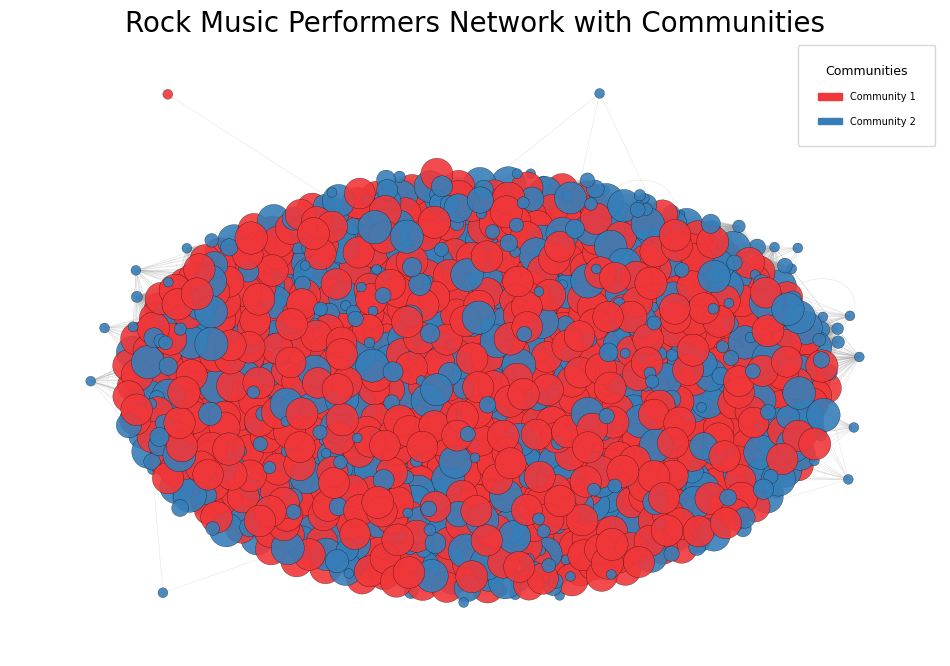

In [132]:

pos = nx.drawing.forceatlas2_layout(G_undirected)

def draw_graph_with_communities(G_undirected, pos, list_communities_louvain, title="Rock Music Performers Network with Communities"):

    # Sort communities by size and keep all communities because they are a few
    partition_sorted = sorted(list_communities_louvain, key=len, reverse=True)
    top_communities = partition_sorted

    # Manage node sizes based on degree
    deg_dict = dict(G_undirected.degree())
    node_sizes = [max(50, d*0.5) for d in deg_dict.values()] 

    # Create a mapping from node to community index
    node_to_comm = {}
    for idx, comm in enumerate(top_communities):
        for node in comm:
            node_to_comm[node] = idx

    # Prepare colormap
    n_colors = max(1, len(top_communities))
    custom_colors = [
        "#f0373a",  
        "#377eb8",  
        "#4daf4a", 
        "#984ea3",  
        "#fba34c",  
        "#fbfb50",  
    ]

    # Buils a node color list based on community membership
    node_colors = []
    for node in G_undirected.nodes():
        comm = node_to_comm.get(node)
        if comm is not None and comm < len(custom_colors):
            node_colors.append(custom_colors[comm])
        else:
            node_colors.append("#d3d3d3")
            

    # Create legend entries for each community color
    legend_patches = [
        mpatches.Patch(color=custom_colors[i], label=f"Community {i + 1}")
        for i in range(len(top_communities))
    ]

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G_undirected, pos, node_color=node_colors, node_size=node_sizes, linewidths=0.2, edgecolors='black', alpha=0.9)
    nx.draw_networkx_edges(G_undirected, pos, alpha=0.4, width=0.3, edge_color="#a9a9a9")
    plt.legend(
        handles=legend_patches, 
        title="Communities", 
        fontsize=7,  # Larger font for legend items
        title_fontsize=9,  # Larger font for legend title
        loc='upper right', 
        markerscale=2,  # Increase marker scale for better visibility
        borderpad=2,  # Increase padding inside the legend box
        labelspacing=1.5,  # Increase space between legend items
        handlelength=2.5  # Increase length of color patches
    )
    plt.axis('off')
    plt.title(title, fontsize=20)
    plt.show()

draw_graph_with_communities(G_undirected, pos, list_communities_louvain)



Backboning Test

In [101]:

#Model 2
def backboning_graph(G, alpha_thresh):
    # Make sure the graph is undirected
    G_undirected = G.copy() 
    
    edge_betweenness = nx.edge_betweenness_centrality(G_undirected, normalized=False)
    normalized_weights = 1 + (np.array(list(edge_betweenness.values())) - min(edge_betweenness.values())) * (99 / (max(edge_betweenness.values()) - min(edge_betweenness.values())))
    # get edges
    edges = list(G_undirected.edges())

    # build the weights dictionary
    normalized_weights_dict = {
    edge: float(normalized_weights[i]) for i, edge in enumerate(edges)
        }

    # assign weights to edges
    nx.set_edge_attributes(G_undirected, normalized_weights_dict, "weight")

    # Suppose that your graph is G with weights 'weight'
    edges_data = [(u, v, w['weight'], w.get('common_subtopics', [])) for u, v, w in G_undirected.edges(data=True)]

    df_edges = pd.DataFrame(edges_data, columns=['src', 'trg', 'nij', 'common_subtopics'])

    # Apply the disparity filter
    df_backbone = backboning.disparity_filter(df_edges[['src', 'trg', 'nij']], undirected=True)
    df_backbone_filtered = df_backbone[df_backbone["score"] < alpha_thresh]


    # To reconstruct a graph from the backbone
    G_backbone = nx.Graph()
    
    for _, row in df_backbone_filtered.iterrows():
        common_subtopics = df_edges.loc[
            (df_edges['src'] == row['src']) & (df_edges['trg'] == row['trg']),
            'common_subtopics'
        ].values[0]
        
        G_backbone.add_edge(
            row['src'], row['trg'], weight=row['nij'], score=row['score'], common_subtopics=common_subtopics
        )
    

    return G_backbone

# Apply backboning with a chosen alpha threshold
alpha_threshold = 0.50
G_backbone = backboning_graph(G_undirected, alpha_threshold)
print("Original number of edges:", G_undirected.number_of_edges())
print("Number of edges in backbone:", G_backbone.number_of_edges())
print("Number of nodes in backbone:", G_backbone.number_of_nodes())

Calculating DF score...


Original number of edges: 379589
Number of edges in backbone: 1516
Number of nodes in backbone: 618


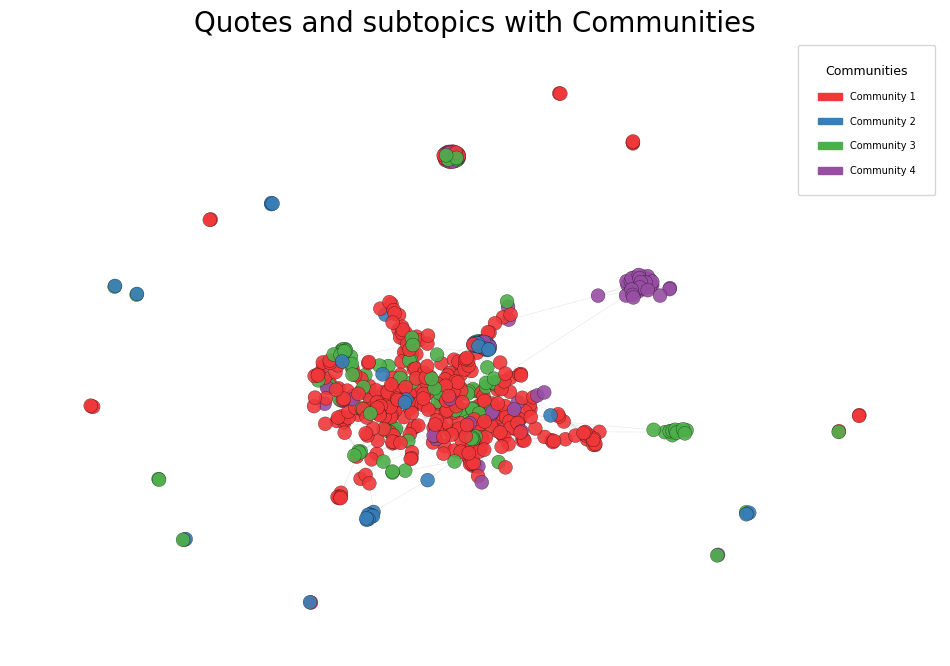

In [102]:
pos_backbone = nx.drawing.forceatlas2_layout(G_backbone, seed=42)
draw_graph_with_communities(G_backbone, pos_backbone, list_communities_louvain,title="Quotes and subtopics with Communities")